In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from keras.utils import np_utils
from nltk.tokenize import RegexpTokenizer
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv('./dataset/hm_train.csv')
test = pd.read_csv('./dataset/hm_test.csv')

In [3]:
train.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,affection
1,27674,24h,I was happy when my son got 90% marks in his e...,1,affection
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise
3,27676,24h,We had a serious talk with some friends of our...,2,bonding
4,27677,24h,I went with grandchildren to butterfly display...,1,affection


In [4]:
test.head()

,hmid,reflection_period,cleaned_hm,num_sentence
0,88305,3m,I spent the weekend in Chicago with my friends.,1
1,88306,3m,We moved back into our house after a remodel. ...,2
2,88307,3m,My fiance proposed to me in front of my family...,1
3,88308,3m,I ate lobster at a fancy restaurant with some ...,1
4,88309,3m,I went out to a nice restaurant on a date with...,5


In [5]:
print(train.shape)
print(test.shape)

(60321, 5)
(40213, 4)


In [6]:
labels = train['predicted_category']
print(np.unique(labels,return_counts=True))

(array(['achievement', 'affection', 'bonding', 'enjoy_the_moment',
       'exercise', 'leisure', 'nature'], dtype=object), array([20274, 20880,  6561,  6508,   729,  4242,  1127]))


In [7]:
label_dict = { 0 : 'achievement', 1 : 'affection', 2 : 'bonding', 3 : 'enjoy_the_moment', 4 : 'exercise', 5 : 'leisure', 6 : 'nature'}

In [8]:
rev_mapping = { 'achievement' : 0, 'affection' : 1, 'bonding' : 2, 'enjoy_the_moment' : 3, 'exercise' : 4, 'leisure' : 5, 'nature' : 6}

In [9]:
train['predicted_category'].replace(rev_mapping, inplace=True)

In [10]:
train.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,1
1,27674,24h,I was happy when my son got 90% marks in his e...,1,1
2,27675,24h,I went to the gym this morning and did yoga.,1,4
3,27676,24h,We had a serious talk with some friends of our...,2,2
4,27677,24h,I went with grandchildren to butterfly display...,1,1


In [11]:
data = train.values

In [12]:
X_train = data[:50000,2]
Y_train = data[:50000,4]

X_test = data[50000:60000,2]
Y_test = data[50000:60000,4]

print (X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print ("-------------------------")
print (X_test[0], Y_test[0])
print (X_train[0], Y_train[0])

(50000,) (50000,) (10000,) (10000,)
-------------------------
when birthday celebrated with my whole family 1
I went on a successful date with someone I felt sympathy and connection with. 1


In [13]:
tokenizer = RegexpTokenizer("[a-zA-Z]+")
lemmatizer = WordNetLemmatizer()

In [14]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/suransh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
for ix in range(X_train.shape[0]):
    X_train[ix] = tokenizer.tokenize(X_train[ix])
    X_train[ix] = [lemmatizer.lemmatize(i) for i in X_train[ix]]
    
for ix in range(X_test.shape[0]):
    X_test[ix] = tokenizer.tokenize(X_test[ix])
    X_test[ix] = [lemmatizer.lemmatize(i) for i in X_test[ix]]
    
Y_train = np_utils.to_categorical(Y_train)

In [16]:
Y_test = np_utils.to_categorical(Y_test)

In [17]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 50000/50000 [00:00<00:00, 599575.15it/s]

21360
1193


In [18]:
len_max = 40

In [19]:
tokenizer_keras = Tokenizer(num_words=len(list(unique_words)))
tokenizer_keras.fit_on_texts(list(X_train))
X_train = tokenizer_keras.texts_to_sequences(X_train)
X_test = tokenizer_keras.texts_to_sequences(X_test)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape,X_test.shape)

(50000, 40) (10000, 40)


In [20]:
print(X_train[0])
print(X_test[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     1    24    16     2   772   329    13   299     1    98
 10237     4  1672    13]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23  97 438
  13   3 310  52]


In [21]:
print(X_train[0],Y_train[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     1    24    16     2   772   329    13   299     1    98
 10237     4  1672    13] [0. 1. 0. 0. 0. 0. 0.]


In [22]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

#Model using Keras LSTM
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           6408000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 707       
Total params: 6,684,263
Trainable params: 6,684,263
Non-trainable params: 0
_________________________________________________________________


In [23]:
checkpoint=ModelCheckpoint('model_best.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [24]:
hist = model.fit(X_train,Y_train,validation_data=(X_test, Y_test),
                epochs = 10, batch_size=32,shuffle=True,callbacks=[checkpoint,early_stopping])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 235s 5ms/step - loss: 0.7263 - acc: 0.7578 - val_loss: 0.4876 - val_acc: 0.8352
Epoch 2/10
50000/50000 [==============================] - 232s 5ms/step - loss: 0.4553 - acc: 0.8555 - val_loss: 0.4159 - val_acc: 0.8637
Epoch 3/10
50000/50000 [==============================] - 233s 5ms/step - loss: 0.3857 - acc: 0.8774 - val_loss: 0.4631 - val_acc: 0.8629
Epoch 4/10
50000/50000 [==============================] - 231s 5ms/step - loss: 0.3642 - acc: 0.8845 - val_loss: 0.4508 - val_acc: 0.8591


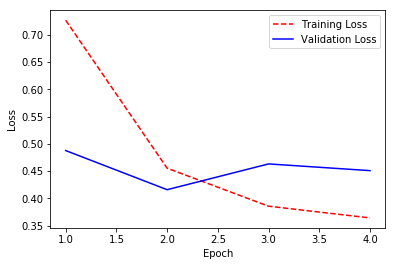

In [25]:
epoch_count = range(1, len(hist.history['loss']) + 1)

plt.plot(epoch_count, hist.history['loss'], 'r--')
plt.plot(epoch_count, hist.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [26]:
data_test = test.values[:,2]
print(data_test.shape)

(40213,)


In [27]:
print(data_test[0])

I spent the weekend in Chicago with my friends.


In [28]:
for ix in range(data_test.shape[0]):
    data_test[ix] = tokenizer.tokenize(data_test[ix])
    data_test[ix] = [lemmatizer.lemmatize(i) for i in data_test[ix]]

In [29]:
data_test = tokenizer_keras.texts_to_sequences(data_test)

data_test = sequence.pad_sequences(data_test, maxlen=len_max)
print(data_test.shape)

(40213, 40)


In [30]:
model = load_model('./model_best.h5')

In [32]:
pred = model.predict_classes(data_test)

In [33]:
test['predicted_category'] = pred

In [34]:
test.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,88305,3m,I spent the weekend in Chicago with my friends.,1,2
1,88306,3m,We moved back into our house after a remodel. ...,2,0
2,88307,3m,My fiance proposed to me in front of my family...,1,1
3,88308,3m,I ate lobster at a fancy restaurant with some ...,1,2
4,88309,3m,I went out to a nice restaurant on a date with...,5,1


In [35]:
test['predicted_category'].replace(label_dict, inplace=True)

In [36]:
test.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,88305,3m,I spent the weekend in Chicago with my friends.,1,bonding
1,88306,3m,We moved back into our house after a remodel. ...,2,achievement
2,88307,3m,My fiance proposed to me in front of my family...,1,affection
3,88308,3m,I ate lobster at a fancy restaurant with some ...,1,bonding
4,88309,3m,I went out to a nice restaurant on a date with...,5,affection


In [37]:
ans_df = pd.DataFrame()

In [38]:
ans_df['hmid'] = test['hmid']

In [39]:
ans_df['predicted_category'] = test['predicted_category']

In [40]:
ans_df.head()

,hmid,predicted_category
0,88305,bonding
1,88306,achievement
2,88307,affection
3,88308,bonding
4,88309,affection


In [41]:
ans_df.to_csv('ans_best_kaggle.csv', sep=',',index=False)